## Supervised Classification Algorithms

### Import libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as pl
import pathlib
import shutil
import numpy as np
import pyspark.sql.functions as F
from data_processing import *
from datetime import datetime
from pyspark.sql.functions import array, col, monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer,VectorAssembler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

<p>Override the <b>printf()</b> function to display output with time</p>

In [6]:
def printf(*arg, **kwarg):
    timestamp = datetime.now().strftime("%H:%M:%S.%f")
    print(f'[{timestamp}]', *arg, **kwarg)

### Split the data set into a training set and test set

<p>We will use the randomSplit() method provided by PySpark to split the dataset into a training set and a test set, with a 2:1 ratio</p>

In [7]:
players = sampled_data()
trainingSet, testSet = players.randomSplit([0.67, 0.33], 24)
# Drop labels of the test set to evaluate later
unlabeledTestSet, testSetRealLabels = testSet.drop(
        "label_position"
    ), testSet.select("label_position").withColumnRenamed(
        "label_position", "real_label"
    )

### Train a model using PySpark

#### K-nearest neighbors algorithm (K-NN)

<p>Since the K-NN model uses distance between data points to predict an unlabeled data point, we need a function to compute their distance as shown below<p> 

In [8]:
def euclidean_distance(v1, v2):
    return np.sum((v1 - v2) ** 2)

<p>We'll train the model using the code below.<p>

In [27]:
def knnModel(trainingSet, toPredictSet, k):
    # Convert features to vectors to compute their distances 
    featuresArray = array(
        "pace",
        "shooting",
        "passing",
        "dribbling",
        "defending",
        "attacking_crossing",
        "attacking_finishing",
        "attacking_heading_accuracy",
        "attacking_short_passing",
        "attacking_volleys",
        "skill_dribbling",
        "skill_fk_accuracy",
        "skill_long_passing",
        "skill_ball_control",
        "movement_acceleration",
        "movement_sprint_speed",
        "movement_agility",
        "movement_balance",
        "power_shot_power",
        "power_stamina",
        "power_long_shots",
        "mentality_interceptions",
        "mentality_positioning",
        "mentality_penalties",
        "defending_marking_awareness",
        "defending_standing_tackle",
        "defending_sliding_tackle",
    )
    # Convert the training set into a DataFrame with two columns: 
    # one column represents feature vectors, and the other column represents a player's position.
    trainingSetDf = trainingSet.select(
        featuresArray.alias("features_in_array_training"), "label_position"
    )
    # Drop labels of the test set and convert its features into vectors
    toPredictSetDf = toPredictSet.select(
        monotonically_increasing_id().alias("id"),
        featuresArray.alias("features_in_array_predict"),
    )
    # Compute cartesian product of two Dataframes
    merged = toPredictSetDf.crossJoin(trainingSetDf)
    mergedRDD = merged.rdd
    mergedRDD = mergedRDD.map(
        lambda r: [
            r.id,
            euclidean_distance(
                np.array(r.features_in_array_predict).astype(float),
                np.array(r.features_in_array_training).astype(float),
            ).tolist(),
            r.label_position,
        ]
    )
    merged = mergedRDD.toDF(["id", "distance", "label_position"])
    
    windowMerged = Window.partitionBy("id").orderBy(col("distance").asc())
    merged = (
        merged.withColumn("row", row_number().over(windowMerged))
        .filter(col("row") <= k)
        .drop("row")
        .drop("distance")
    )
    # Get distances between an unlabeled data point with its K nearest neighbors
    merged = merged.groupBy(["id", "label_position"]).count()
    windowMerged = Window.partitionBy("id").orderBy(col("count").desc())
    # Obtain the majority labels of its K nearest neighbors
    merged = (
        merged.withColumn("row", row_number().over(windowMerged))
        .filter(col("row") == 1)
        .drop("row")
        .drop("count")
    )
    merged = merged.orderBy("id").drop("id")
    merged = merged.withColumnRenamed("label_position", "prediction")
    return merged

<p>Now we will train our model using the training set<p>

In [28]:
testSetPredictions = knnModel(trainingSet, unlabeledTestSet, k=3)

#### Model Evaluation

The model will be evaluated as shown below:

In [32]:
def evaluation(testSetLabels, predictions):
    # Compute evaluation metrics
    cr = classification_report(testSetLabels,predictions, output_dict=True)
    report_df = pd.DataFrame.from_dict(cr).transpose()
    print("Classification Report:")
    print(report_df)
    cm = confusion_matrix(testSetLabels, predictions)
    print("\nConfusion Matrix")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =['Forward', 'Midfielder', 'Defender'])
    disp.plot()
    pl.show()


[23:19:21.655502] Evaluating predictions...

Classification Report:
              precision    recall  f1-score     support
Defender       0.892405  0.903846  0.898089  156.000000
Forward        0.803468  0.896774  0.847561  155.000000
Midfielder     0.776978  0.679245  0.724832  159.000000
accuracy       0.825532  0.825532  0.825532    0.825532
macro avg      0.824284  0.826622  0.823494  470.000000
weighted avg   0.824026  0.825532  0.822813  470.000000

Confusion Matrix


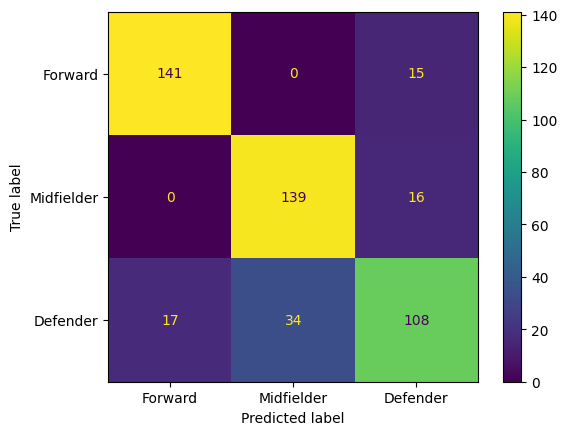

In [33]:
# Compute evaluation metrics
printf("Evaluating predictions...\n")
evaluation(testSetRealLabels.toPandas(),testSetPredictions.toPandas())

<p><b>Observation:</b> Our models have been trained on a subsample of 1500 data points, which is much smaller than the original dataset. However, increasing the size of the subsample can take hours to train a model. As a result, we have decided to use Apache Parquet, which can generate lower storage costs for data and maximize the effectiveness of data queries. This allows a large amount of data to fit in memory, reducing the time for swapping data from disks. We will save the training set and test set as .parquet. This process is done as shown below:</p>

In [34]:
def cleanup_data_and_store_as_parquet(players):
    trainingSet, testSet = players.randomSplit([0.67, 0.33], 24)
    male_players_cleaned_training = pathlib.Path("../data/male_players_cleaned_training")
    if male_players_cleaned_training.exists():
         shutil.rmtree("../data/male_players_cleaned_training",ignore_errors=True)
    male_players_cleaned_test = pathlib.Path("../data/male_players_cleaned_test")
    if male_players_cleaned_test.exists():
        shutil.rmtree("../data/male_players_cleaned_test",ignore_errors=True)
        
    trainingSet.write.parquet('../data/male_players_cleaned_training')
    testSet.write.parquet('../data/male_players_cleaned_test') 

# Read the dataset using PySpark
players = data_preparation("../data/male_players.csv")
cleanup_data_and_store_as_parquet(players)
printf("-------Using the entire of data set-------")
printf("Loading dataset...")

# Retrieve training set and test set 
trainingSet = pd.read_parquet('../data/male_players_cleaned_training')
testSet = pd.read_parquet('../data/male_players_cleaned_test')
printf(f'Finished loading dataset. Training set: {trainingSet.shape[0]} rows, Test set: {testSet.shape[0]} rows')

# Get labels of the training set
trainingSetLabels = trainingSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the training set 
trainingSet = trainingSet.iloc[:, :-1]

# Get labels of the test set
testSetLabels = testSet.iloc[:, -1:].values.ravel()
# Drop the column "label_positions" of the test set
testSet = testSet.iloc[:, :-1]

[23:20:24.061077] -------Using the entire of data set-------
[23:20:24.061077] Loading dataset...
[23:20:25.201269] Finished loading dataset. Training set: 5952255 rows, Test set: 2930183 rows


### Train a model using Scikit-Learn

<p>As PySpark does not implement the K-NN model, we developed our own implementation. However, our algorithm is computationally expensive because we generated a Cartesian product between the training set and test set. Fortunately, Scikit-Learn offers optimized K-NN models that use BallTree and KDTree for efficient nearest-neighbor searches.
</p>
<p>We will now create a <b>predict()</b> method.</p>

In [35]:
def predict(model, name, trainingSet, trainingSetLabels, testSetLabels):
    printf(f'Fitting {name} model...')
    model.fit(trainingSet, trainingSetLabels)
    printf(f"Finished fitting model.")

    printf("Predicting test labels...")

    predictions = model.predict(testSet)
    printf("Finished predictions.")
    return predictions

#### Train model using K-nearest neighbors algorithm 

<p>We'll train KNN model using the code below.</p>

In [36]:
knn_model = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', n_jobs=-1)
knn_predictions = predict(knn_model,"KNN",trainingSet, trainingSetLabels, testSetLabels)

[23:22:49.189397] Fitting KNN model...
[23:23:42.752444] Finished fitting model.
[23:23:42.753444] Predicting test labels...
[23:26:56.298221] Finished predictions.


#### Train model using Random Forest algorithm 

In [37]:
rf_model = RandomForestClassifier(max_depth=7, random_state=0)
rf_predictions = predict(rf_model,"Random Forest",trainingSet, trainingSetLabels, testSetLabels)

[23:27:04.366121] Fitting Random Forest model...
[23:40:00.156653] Finished fitting model.
[23:40:00.156653] Predicting test labels...
[23:40:17.925654] Finished predictions.


#### Train model using Decision Tree algorithm 

In [40]:
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=7)
dt_predictions = predict(dt_model, "Decision Tree", trainingSet, trainingSetLabels, testSetLabels)

[23:46:14.318559] Fitting Decision Tree model...
[23:47:05.606838] Finished fitting model.
[23:47:05.606838] Predicting test labels...
[23:47:05.905384] Finished predictions.


#### Model Evaluation

#### Evaluate a model trained by K-NN algorithm

[23:42:45.398115] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.996970  0.998159  0.997564  1.076063e+06
Forward        0.990663  0.989259  0.989961  6.278720e+05
Midfielder     0.993042  0.992724  0.992883  1.226248e+06
accuracy       0.993978  0.993978  0.993978  9.939775e-01
macro avg      0.993559  0.993381  0.993469  2.930183e+06
weighted avg   0.993975  0.993978  0.993976  2.930183e+06

Confusion Matrix


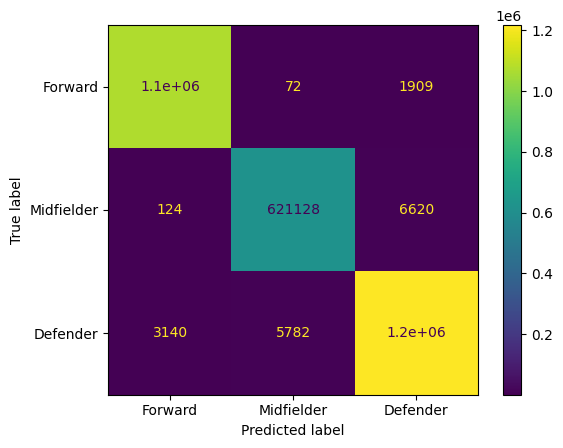

In [38]:
printf("Evaluating predictions...\n")
evaluation(testSetLabels,knn_predictions)

#### Evaluate a model trained by Random Forest algorithm

[23:44:31.835212] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.907044  0.928578  0.917685  1.076063e+06
Forward        0.882934  0.787626  0.832561  6.278720e+05
Midfielder     0.835818  0.864602  0.849967  1.226248e+06
accuracy       0.871602  0.871602  0.871602  8.716019e-01
macro avg      0.875266  0.860269  0.866737  2.930183e+06
weighted avg   0.872071  0.871602  0.871105  2.930183e+06

Confusion Matrix


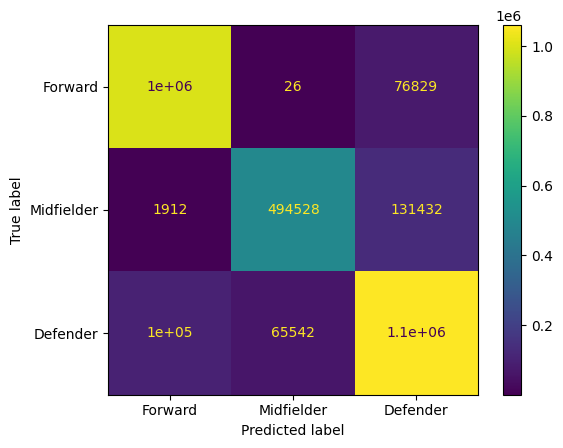

In [39]:
printf("Evaluating predictions...\n")
evaluation(testSetLabels,rf_predictions)

#### Evaluate a model trained by Decision Tree algorithm

[23:47:35.713355] Evaluating predictions...

Classification Report:
              precision    recall  f1-score       support
Defender       0.890546  0.896441  0.893484  1.076063e+06
Forward        0.877018  0.753139  0.810372  6.278720e+05
Midfielder     0.798378  0.851482  0.824075  1.226248e+06
accuracy       0.846920  0.846920  0.846920  8.469198e-01
macro avg      0.855314  0.833687  0.842644  2.930183e+06
weighted avg   0.849076  0.846920  0.846628  2.930183e+06

Confusion Matrix


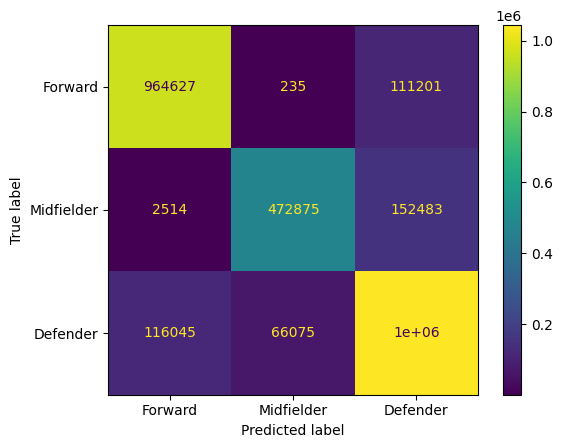

In [41]:
printf("Evaluating predictions...\n")
evaluation(testSetLabels,dt_predictions)